# Справка
Подходящие для выгрузки всех стран годы:

'2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021'


Подходящие для выгрузки всех лет страны:

'Antigua and Barbuda', 'Argentina', 'Australia', 'Austria', 'Belgium',
'Belize', 'Bermuda', 'Brazil', 'Bulgaria', 'Canada', 'Denmark',
'Dominica', 'Ecuador', 'El Salvador', 'Finland', 'France',
'Hong Kong SAR', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy',
'Japan', 'Mexico', 'New Zealand', 'Norway', 'Paraguay', 'Poland',
'Romania', 'Saint Kitts and Nevis', 'Spain', 'Sri Lanka', 'Switzerland',
'United Kingdom', 'United Kingdom, England and Wales',
'United Kingdom, Northern Ireland', 'United Kingdom, Scotland',
'United States of America', 'Uruguay', 'Venezuela'

Измените ниже год для задания 1 и страну для задания 2. Не стирайте скобки и кавычки.

Для запуска ячейки в режиме ее редактирования нажмите shift+enter

In [1]:
year = ['2015']
country = ['Switzerland']

Запустите ячейки ниже до следующих инструкций

Достаточно нажать все вот такие кнопки

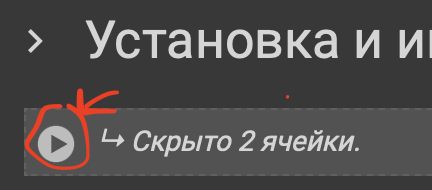

# Установка и импорты необходимых библиотек

In [2]:
!pip install pandas numpy seaborn matplotlib requests python-docx beautifulsoup4 doc2docx Spire.Doc Spire.Xls

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 8.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import io
import requests
import os
import traceback
import gc
from bs4 import BeautifulSoup
from spire.doc import *
from spire.doc.common import *
from spire.xls import *
from spire.xls.common import *

import warnings
warnings.filterwarnings("ignore")

# Конфигурация (актуально на 06.09.2024)

In [4]:
class ExtractorWHOConfig:
  def __init__(self):
    # URL страницы в WHO с архивами данных
    self.url = 'https://www.who.int/data/data-collection-tools/who-mortality-database'

    # путь к расположению данного скрипта
    self.current_path = os.getcwd()

    # путь, по которому будут размещены выгруженные даныне
    self.extract_path = self.current_path + "/extracted_files/"

    # маска, по которой опознаются названия файлов по смертям
    self.morticd_mask = "morticd"

    # маска, по которой опознаётся файл - справочник стран
    self.list_ctry_years_mask = "list_ctry_years"

    # маска, по которой опознаётся файл по населению и рождениям
    self.pop_mask = "pop"

    # колонки, которые нужно интерпретировать как строковые
    self.str_columns = ['Country', 'Admin1', 'SubDiv', 'Year', 'List', 'Sex', 'name']

    # колонки для объединения файлов со смертями и справочником стран
    self.merge_columns_deaths_list_cntry_years = ['Country', 'Admin1', 'SubDiv', 'Year', 'List']

    # колонки для объединения файлов со смертями и населением
    self.merge_columns_deaths_pop = ['Country', 'Admin1', 'SubDiv', 'Year', 'Sex']

    # набор стран по умолчанию
    self.default_country_names = ['Russian Federaion']

    # набор годов по умолчанию
    self.default_years = ['2020']

config = ExtractorWHOConfig()

# Формирование выгрузки

In [5]:
class ExtractorWHO:
  """Интерфейс для загрузки и чтения данных"""
  def __init__(self, config):
    self.config: ExtractorWHOConfig = config
    self.list_ctry_years_df: pd.DataFrame = None
    self.deaths_df: pd.DataFrame = None
    self.pop_df: pd.DataFrame = None
    self._extracted_file_names = None
    self.available_countries = None
    self.available_years = None
    self.country_codes = []
    self.country_names = []
    self.years = []

  def load_data_from_site(self):
    """Выгружает данные с сайта и записывает в config.extract_path"""
    page = requests.get(self.config.url).content
    soup = BeautifulSoup(page, 'lxml')
    for x in soup.find_all("a"):
      if '.zip' in x.text:
        r_link = x.get('href')
        r = requests.get(r_link)
        content = r.content
        with zipfile.ZipFile(io.BytesIO(content)) as zf:
          zf.extractall(self.config.extract_path)

  def read_list_cntry_years(self):
    """Читает выгруженный справочник стран"""
    self._extracted_file_names = os.listdir(self.config.extract_path)
    mask = self.config.list_ctry_years_mask
    matching_filenames = [f for f in self._extracted_file_names if mask in f]
    if len(matching_filenames) > 1:
      raise Exception(f"Найдено {len(matching_filenames) + 1} файлов, ожидался единственный: {matching_filenames}")
    elif len(matching_filenames) == 0:
      raise Exception("Не найдено ни одного подходящего файла")
    else:
      list_ctry_years_filename = matching_filenames[0]
      list_ctry_years_path = self.config.extract_path + "/" + list_ctry_years_filename
      list_ctry_years_df = pd.read_excel(list_ctry_years_path, sheet_name='avail_mortality')
      list_ctry_years_df = pd.DataFrame(
          data=list_ctry_years_df[7:].values,
          columns=list_ctry_years_df[6:7].values[0]
      )
      print(f'Найдены страны:\n{list_ctry_years_df.name.unique()}')
      self.list_ctry_years_df = list_ctry_years_df
      self.available_countries = list_ctry_years_df['name'].unique()
      self.available_years = list_ctry_years_df['Year'].unique()

  def available_countries_by_year(self, year):
    """Выводит все страны, доступные для года year"""
    list_ctry_years_df = self.list_ctry_years_df
    sub_df = list_ctry_years_df.loc[list_ctry_years_df['Year'] == str(year)]
    countries = sub_df['name'].unique()
    return countries

  def available_years_by_country(self, country_name):
    """Выводит все годы, доступные для страны country_name"""
    list_ctry_years_df = self.list_ctry_years_df
    sub_df = list_ctry_years_df.loc[list_ctry_years_df['name'] == str(country_name)]
    years = sub_df['Year'].unique()
    return years

  def read_data(self, country_names=['Russian Federation', 'United States of America'], years=['2010']):
    """Записывает в аттрибут merged_df несгруппированные по причинам данные для стран country_names, лет years"""
    self.country_names = country_names
    self.years = years
    self.preprocess_list_ctry_years_df()
    self.read_deaths_df()
    self.preprocess_deaths_df()
    self.read_pop()
    self.preprocess_pop_df()
    self.merge_dfs()
    self.rename_merge_df_columns()

  def preprocess_list_ctry_years_df(self):
    self.list_ctry_years_df = self.list_ctry_years_df.loc[
      (self.list_ctry_years_df['name'].isin(self.country_names))
      & (self.list_ctry_years_df['Year'].astype('str').isin(self.years))
    ]
    for str_column in set(self.config.str_columns) & set(self.list_ctry_years_df.columns):
      self.list_ctry_years_df[str_column] = self.list_ctry_years_df[str_column].astype('str')
    self.country_codes = list(self.list_ctry_years_df['Country'].unique())

  def read_deaths_df(self):
    need_icds = self.list_ctry_years_df['Icd'].str.extract('(\d+)')[0].unique()
    dfs = []
    for icd in need_icds:
      deaths_file_mask = self.config.morticd_mask + icd
      for filename in self._extracted_file_names:
        if deaths_file_mask in filename.lower():
          print(f"reading {filename}")
          file_path = self.config.extract_path + "/" + filename
          df_temp = pd.read_csv(file_path)
          print(f"- found {len(df_temp)} rows")
          df_temp = df_temp.loc[
            (df_temp['Country'].astype('str').isin(self.country_codes))
            & (df_temp['Year'].astype('str').isin(self.years))
          ]
          dfs.append(df_temp)
          del df_temp
          gc.collect()
    self.deaths_df = pd.concat(dfs)

  def preprocess_deaths_df(self):
    for str_column in set(self.config.str_columns) & set(self.deaths_df.columns):
      self.deaths_df[str_column] = self.deaths_df[str_column].astype('str')

  def read_pop(self):
    for filename in self._extracted_file_names:
      mask = self.config.pop_mask
      matching_filenames = [f for f in self._extracted_file_names if mask in f]
      if len(matching_filenames) > 1:
        raise Exception(f"Найдено {len(matching_filenames) + 1} файлов, ожидался единственный: {matching_filenames}")
      elif len(matching_filenames) == 0:
        raise Exception("Не найдено ни одного подходящего файла")
      else:
        pop_filename = matching_filenames[0]
        pop_path = self.config.extract_path + "/" + pop_filename
        pop_df = pd.read_csv(pop_path)
        pop_df = pop_df.loc[
          (pop_df['Country'].astype('str').isin(self.country_codes))
          & (pop_df['Year'].astype('str').isin(self.years))
        ]
        self.pop_df = pop_df

  def preprocess_pop_df(self):
    for str_column in set(self.config.str_columns) & set(self.pop_df.columns):
      self.pop_df[str_column] = self.pop_df[str_column].astype('str')

  def merge_dfs(self):
    merged_df = self.deaths_df.merge(
      right=self.list_ctry_years_df,
      how='left',
      left_on=self.config.merge_columns_deaths_list_cntry_years,
      right_on=self.config.merge_columns_deaths_list_cntry_years
    )
    merged_df = merged_df.merge(
      right=self.pop_df,
      how='left',
      left_on=self.config.merge_columns_deaths_pop,
      right_on=self.config.merge_columns_deaths_pop
    )
    self.merged_df = merged_df
    del self.deaths_df
    # del self.list_ctry_years_df
    del self.pop_df
    gc.collect()

  def rename_merge_df_columns(self):
    self.merged_df = self.merged_df.rename(
        columns={
          'Country': 'CountryCode',
          'name': 'CountryName',
          'Deaths1': 'D',
          'Deaths2': 'D_0',
          'Deaths3': 'D_1',
          'Deaths4': 'D_2',
          'Deaths5': 'D_3',
          'Deaths6': 'D_4',
          'Deaths7': 'D_5_9',
          'Deaths8': 'D_10_14',
          'Deaths9': 'D_15_19',
          'Deaths10': 'D_20_24',
          'Deaths11': 'D_25_29',
          'Deaths12': 'D_30_34',
          'Deaths13': 'D_35_39',
          'Deaths14': 'D_40_44',
          'Deaths15': 'D_45_49',
          'Deaths16': 'D_50_54',
          'Deaths17': 'D_55_59',
          'Deaths18': 'D_60_64',
          'Deaths19': 'D_65_69',
          'Deaths20': 'D_70_74',
          'Deaths21': 'D_75_79',
          'Deaths22': 'D_80_84',
          'Deaths23': 'D_85_89',
          'Deaths24': 'D_90_94',
          'Deaths25': 'D_95_',
          'Deaths26': 'D_unspecified',
          'Pop1': 'N',
          'Pop2': 'N_0',
          'Pop3': 'N_1',
          'Pop4': 'N_2',
          'Pop5': 'N_3',
          'Pop6': 'N_4',
          'Pop7': 'N_5_9',
          'Pop8': 'N_10_14',
          'Pop9': 'N_15_19',
          'Pop10': 'N_20_24',
          'Pop11': 'N_25_29',
          'Pop12': 'N_30_34',
          'Pop13': 'N_35_39',
          'Pop14': 'N_40_44',
          'Pop15': 'N_45_49',
          'Pop16': 'N_50_54',
          'Pop17': 'N_55_59',
          'Pop18': 'N_60_64',
          'Pop19': 'N_65_69',
          'Pop20': 'N_70_74',
          'Pop21': 'N_75_79',
          'Pop22': 'N_80_84',
          'Pop23': 'N_85_89',
          'Pop24': 'N_90_94',
          'Pop25': 'N_95_',
          'Pop26': 'N_unspecified',
          'Lb': 'B'
        }
    )


  def mark_cause_groups(self, drop_other=True):
    """Размечаем классы причин смерти"""
    def split_cause_symbols(row):
      cause = row['Cause']
      letters = "".join([char for char in cause if char.isalpha()])
      digits = "".join([char for char in cause if char.isdigit()])
      return [letters, digits]

    def mark_103_104(cause, cause_letters, cause_digits):
      n_digits = len(cause_digits)
      if n_digits == 2:
        cause_digits = int(cause_digits)
      elif n_digits == 3:
        cause_digits = int(cause_digits) // 10
      else:
        pass
      if cause in ["U071", "U072", "U099", "U109", "D649"]:
        cause_category = "Communicable, maternal, perinatal and nutritional conditions"
      elif ((cause_letters == 'A')
            or (cause_letters == 'B')
            or ((cause_letters == 'D') and (cause_digits >= 50) and (cause_digits <= 53))
            or ((cause_letters == 'E') and (cause_digits >= 0) and (cause_digits <= 2))
            or ((cause_letters == 'E') and (cause_digits >= 40) and (cause_digits <= 46))
            or ((cause_letters == 'E') and (cause_digits >= 50) and (cause_digits <= 64))
            or ((cause_letters == 'G') and (cause_digits >= 0) and (cause_digits <= 4))
            or ((cause_letters == 'G') and (cause_digits == 14))  # (cause == 'G14')
            or ((cause_letters == 'H') and (cause_digits >= 65) and (cause_digits <= 66))
            or ((cause_letters == 'J') and (cause_digits >= 0) and (cause_digits <= 22))
            or ((cause_letters == 'N') and (cause_digits >= 70) and (cause_digits <= 73))
            or ((cause_letters == 'O') and (cause_digits >= 0) and (cause_digits <= 99))
            or ((cause_letters == 'P') and (cause_digits >= 0) and (cause_digits <= 96))
            or ((cause_letters == 'U') and (cause_digits == 4))  # (cause == 'U04')
          ):
        cause_category = "Communicable, maternal, perinatal and nutritional conditions"
      elif (((cause_letters == 'C') and (cause_digits >= 0) and (cause_digits <= 97))
            or ((cause_letters == 'D') and (cause_digits >= 0) and (cause_digits <= 48))
            or ((cause_letters == 'D') and (cause_digits >= 55) and (cause_digits <= 63))
            or ((cause_letters == 'D') and (cause_digits == 64) and (cause != 'D649'))
            or ((cause_letters == 'D') and (cause_digits >= 65) and (cause_digits <= 89))
            or ((cause_letters == 'E') and (cause_digits >= 3) and (cause_digits <= 7))
            or ((cause_letters == 'E') and (cause_digits >= 10) and (cause_digits <= 34))
            or ((cause_letters == 'E') and (cause_digits >= 65) and (cause_digits <= 88))
            or ((cause_letters == 'F') and (cause_digits >= 1) and (cause_digits <= 99))
            or ((cause_letters == 'G') and (cause_digits >= 6) and (cause_digits <= 13))
            or ((cause_letters == 'G') and (cause_digits >= 15) and (cause_digits <= 98))
            or ((cause_letters == 'H') and (cause_digits >= 0) and (cause_digits <= 61))
            or ((cause_letters == 'H') and (cause_digits >= 68) and (cause_digits <= 93))
            or ((cause_letters == 'I') and (cause_digits >= 0) and (cause_digits <= 99))
            or ((cause_letters == 'J') and (cause_digits >= 30) and (cause_digits <= 98))
            or ((cause_letters == 'K') and (cause_digits >= 0) and (cause_digits <= 92))
            or ((cause_letters == 'L') and (cause_digits >= 0) and (cause_digits <= 98))
            or ((cause_letters == 'M') and (cause_digits >= 0) and (cause_digits <= 99))
            or ((cause_letters == 'N') and (cause_digits >= 0) and (cause_digits <= 64))
            or ((cause_letters == 'N') and (cause_digits >= 75) and (cause_digits <= 98))
            or ((cause_letters == 'Q') and (cause_digits >= 0) and (cause_digits <= 99))
            or ((cause_letters == 'R') and (cause_digits == 95))  # (cause == 'R95')
            or ((cause_letters == 'X') and (cause_digits == 41))  # (cause == 'X41')
            or ((cause_letters == 'X') and (cause_digits == 42))  # (cause == 'X42')
            or ((cause_letters == 'X') and (cause_digits == 44))  # (cause == 'X44')
            or ((cause_letters == 'X') and (cause_digits == 45))  # (cause == 'X45')
          ):
        cause_category = "Noncommunicable diseases"
      elif (((cause_letters == 'V') and (cause_digits >= 0) and (cause_digits <= 99))
            or ((cause_letters == 'W') and (cause_digits >= 0) and (cause_digits <= 99))
            or ((cause_letters == 'X') and (cause_digits >= 0) and (cause_digits <= 40))
            or ((cause_letters == 'X') and (cause_digits == 43))  # cause == 'X43')
            or ((cause_letters == 'X') and (cause_digits >= 46) and (cause_digits <= 99))
            or ((cause_letters == 'Y') and (cause_digits >= 0) and (cause_digits <= 89))
          ):
        cause_category = "Injuries"
      elif (((cause_letters == 'R') and (cause_digits >= 0) and (cause_digits <= 94))
            or ((cause_letters == 'R') and (cause_digits >= 96) and (cause_digits <= 99))
            or (cause == "U129")
          ):
        cause_category = "Ill-defined diseases"
      else:
        cause_category = "Other"
      return cause_category

    def mark_101(cause, cause_letters, cause_digits):
      if cause in [
            '1001',  '1002',  '1003',  '1004',  '1005',  '1006',  '1007',  '1008',  '1009',  '1010',  '1011',  '1012',  '1013',  '1014',  '1015',  '1016',  '1017',  '1018',  '1019',  '1020',  '1021',  '1022',  '1023',  '1024',  '1025',  '1053',  '1059',  '1073',  '1074',  '1075',  '1087',  '1088',  '1089',  '1090',  '1091',  '1092'
          ]:
        cause_category = "Communicable, maternal, perinatal and nutritional conditions"
      elif cause in [
            '1026',  '1027',  '1028',  '1029',  '1030',  '1031',  '1032',  '1033',  '1034',  '1035',  '1036',  '1037',  '1038',  '1039',  '1040',  '1041',  '1042',  '1043',  '1044',  '1045',  '1046',  '1047',  '1050',  '1052',  '1055',  '1056',  '1057',  '1060',  '1062',  '1064',  '1065',  '1066',  '1067',  '1068',  '1069',  '1070',  '1071',  '1076',  '1078',  '1079',  '1080',  '1081',  '1082',  '1083',  '1084',  '1085',  '1086',  '1093'
          ]:
        cause_category = "Noncommunicable diseases"
      elif cause in [
            '1096',  '1097',  '1098',  '1099',  '1101',  '1102',  '1103'
          ]:
        cause_category = "Injuries"
      elif cause in [
            '1048',  '1049',  '1051',  '1054',  '1058',  '1061',  '1063',  '1072',  '1077',  '1094',  '1095',  '1100',
          ]:
        cause_category = "Non-splittable cause group"
      else:
        cause_category = "Other"
      return cause_category

    def mark_07A(cause, cause_letters, cause_digits):
      if cause in [
            'A001',  'A002',  'A003',  'A004',  'A005',  'A006',  'A007',  'A008',  'A009',  'A010',  'A011',  'A012',  'A013',  'A014',  'A015',  'A016',  'A017',  'A018',  'A019',  'A020',  'A021',  'A022',  'A023',  'A024',  'A025',  'A026',  'A027',  'A028',  'A029',  'A030',  'A031',  'A032',  'A033',  'A034',  'A035',  'A036',  'A037',  'A038',  'A039',  'A040',  'A041',  'A042',  'A043',  'A064',  'A071',  'A077',  'A087',  'A088',  'A089',  'A090',  'A091',  'A092',  'A115',  'A116',  'A117',  'A118',  'A119',  'A120', 'A130',  'A131',  'A132',  'A133',  'A134',  'A135'
          ]:
        cause_category = "Communicable, maternal, perinatal and nutritional conditions"
      elif cause in [
            'A044',  'A045',  'A046',  'A047',  'A048',  'A049',  'A050',  'A051',  'A052',  'A053',  'A054',  'A055',  'A056',  'A057',  'A058',  'A059',  'A060',  'A061',  'A062',  'A063',  'A065', 'A066',  'A067',  'A068',  'A069',  'A070',  'A072',  'A073',  'A074',  'A075',  'A076',  'A078',  'A079',  'A080',  'A081',  'A082',  'A083',  'A084',  'A085',  'A086',  'A093',  'A094',  'A095',  'A096',  'A097',  'A098',  'A099',  'A100',  'A101',  'A102',  'A103',  'A104',  'A105',  'A106',  'A107',  'A108',  'A109',  'A110',  'A111',  'A112',  'A113',  'A114',  'A121',  'A122',  'A123',  'A124',  'A125',  'A126',  'A127',  'A128',  'A129', '140',  '141',  '142',  '143',  '144',  '145',  '146',  '147',  '148',  '150',  '151',  '152',  '153',  '154',  '155',  '1550',  '1551',  '156',  '157',  '158',  '159',  '160',  '161',  '162',  '163',  '164',  '165',  '170',  '171',  '172',  '173',  '174',  '175',  '176',  '177',  '178',  '179',  '1790',  '180',  '181',  '1810',  '190',  '191',  '192',  '193',  '194',  '195',  '196',  '197',  '198',  '199',  '200',  '201',  '202',  '203',  '204',  '205'
          ]:
        cause_category = "Noncommunicable diseases"
      elif (cause in [
            'A138',  'A139',  'A140',  'A141',  'A142',  'A143',  'A144',  'A145',  'A146',  'A147',  'A148',  'A149',  'A150',  'S47',  'CH17'
          ]) or (int(cause_digits) >= 210):
        cause_category = "Injuries"
      elif cause in [
            'A136',  'A137'
          ]:
        cause_category = "Ill-defined diseases"
      else:
        cause_category = "Other"
      return cause_category

    def mark_08A(cause, cause_letters, cause_digits):
      if cause in [
            'A001',  'A002',  'A003',  'A004',  'A005',  'A006',  'A007',  'A008',  'A009',  'A010',  'A011',  'A012',  'A013',  'A014',  'A015',  'A016',  'A017',  'A018',  'A019',  'A020',  'A021',  'A022',  'A023',  'A024',  'A025',  'A026',  'A027',  'A028',  'A029',  'A030',  'A031',  'A032',  'A033',  'A034',  'A035',  'A036',  'A037',  'A038',  'A039',  'A040',  'A041',  'A042',  'A043',  'A044',  'A065',  'A072',  'A078',  'A089',  'A090',  'A091',  'A092',  'A112',  'A113',  'A114',  'A115',  'A116',  'A117',  'A118',  'A131',  'A132',  'A133',  'A134',  'A135'
          ]:
        cause_category = "Communicable, maternal, perinatal and nutritional conditions"
      elif cause in [
            'A045',  'A046',  'A047',  'A048',  'A049',  'A050',  'A051',  'A052',  'A053',  'A054',  'A055',  'A056',  'A057',  'A058',  'A059',  'A060',  'A061',  'A062',  'A063',  'A064',  'A065', 'A066',  'A067', 'A068',  'A069',  'A070',  'A071',  'A073',  'A074',  'A075',  'A076',  'A077',  'A079',  'A080',  'A081',  'A082',  'A083',  'A084',  'A085',  'A086',  'A087',  'A088',  'A093',  'A094',  'A095',  'A096',  'A097',  'A098',  'A099',  'A100',  'A101',  'A102',  'A103',  'A104',  'A105',  'A106',  'A107',  'A108',  'A109',  'A110',  'A111',  'A119',  'A120',  'A121',  'A122',  'A123',  'A124',  'A125',  'A126',  'A127',  'A128',  'A129',  'A130', '140',  '141',  '142',  '143',  '1431',  '144',  '145',  '146',  '147',  '148',  '149',  '150',  '151',  '152',  '153',  '154',  '155',  '156',  '157',  '158',  '159',  '160',  '161',  '162',  '163',  '1630',  '170',  '171',  '172',  '1725',  '173',  '1735',  '174',  '180',  '181',  '182',  '1820',  '183',  '184',  '185',  '186',  '187',  '188',  '189',  '1890',  '1891',  '1892',  '1899',  '190',  '191',  '192',  '1920',  '1921',  '1922',  '1925',  '193',  '194',  '195',  '196',  '197',  '1970',  '1971',  '1972',  '1973',  '1974',  '1975',  '1976',  '1977',  '1978',  '1979',  '198',  '199',  '200',  '2000',  '2001',  '201',  '202',  '2020',  '2021',  '2022',  '2029',  '203',  '204',  '205',  '206',  '207',  '208',  '209',  '210',  '211',  '212',  '213',  '214',  '215',  '216',  '217',  '218',  '219',  '220',  '221',  '222',  '223',  '224',  '225',  '226',  '227',  '228',  '230',  '231',  '232',  '233',  '234',  '235',  '236',  '237',  '238',  '239'
          ]:
        cause_category = "Noncommunicable diseases"
      elif cause in [
            'A138',  'A139',  'A140',  'A141',  'A142',  'A143',  'A144',  'A145',  'A146',  'A147',  'A148',  'A149',  'A150',  'S47'
          ]:
        cause_category = "Injuries"
      elif cause in [
            'A136',  'A137'
          ]:
        cause_category = "Ill-defined diseases"
      else:
        cause_category = "Other"
      return cause_category

    def mark_09A_09B(cause, cause_letters, cause_digits):
      if cause in [
            'B01', 'B010', 'B011', 'B012', 'B013', 'B014', 'B015', 'B016', 'B019', 'B02', 'B020', 'B021', 'B022', 'B023', 'B024', 'B025', 'B029', 'B03', 'B030', 'B031', 'B032', 'B033', 'B034', 'B035', 'B036', 'B037', 'B038', 'B039', 'B04', 'B040', 'B041', 'B042', 'B043', 'B044', 'B045', 'B046', 'B047', 'B048', 'B049', 'B05', 'B050', 'B051', 'B052', 'B053', 'B054', 'B059', 'B06', 'B060', 'B061', 'B069', 'B07', 'B070', 'B071', 'B072', 'B073', 'B074', 'B075', 'B076', 'B077', 'B078', 'B079', 'B184', 'B185', 'B19', 'B190', 'B191', 'B192', 'B193', 'B199', 'B220', 'B240', 'B310', 'B311', 'B312', 'B320', 'B321', 'B322', 'B371', 'B372', 'B373', 'B38', 'B380', 'B381', 'B382', 'B389', 'B39', 'B390', 'B391', 'B392', 'B393', 'B394', 'B399', 'B40', 'B41', 'B45', 'B450', 'B451', 'B452', 'B453', 'B454', 'B455', 'B459', 'B466'
          ]:
        cause_category = "Communicable, maternal, perinatal and nutritional conditions"
      elif cause in [
            'B08', 'B09', 'B090', 'B091', 'B092', 'B093', 'B094', 'B095', 'B096', 'B099', 'B10', 'B100', 'B101', 'B109', 'B11', 'B110', 'B111', 'B112', 'B113', 'B119', 'B12', 'B120', 'B121', 'B122', 'B123', 'B124', 'B125', 'B126', 'B129', 'B13', 'B130', 'B139', 'B14', 'B140', 'B141', 'B149', 'B15', 'B150', 'B151', 'B152', 'B153', 'B154', 'B155', 'B156', 'B159', 'B16', 'B17', 'B180', 'B181', 'B182', 'B183', 'B209', 'B21', 'B210', 'B211', 'B212', 'B213', 'B214', 'B215', 'B216', 'B217', 'B218', 'B219', 'B22', 'B221', 'B222', 'B223', 'B224', 'B225', 'B229', 'B23', 'B230', 'B231', 'B232', 'B233', 'B234', 'B235', 'B239', 'B241', 'B249', 'B25', 'B250', 'B251', 'B259', 'B26', 'B260', 'B269', 'B27', 'B270', 'B279', 'B28', 'B280', 'B281', 'B289', 'B29', 'B290', 'B291', 'B292', 'B293', 'B294', 'B299', 'B30', 'B300', 'B301', 'B302', 'B303', 'B304', 'B305', 'B309', 'B313', 'B314', 'B315', 'B319', 'B323', 'B324', 'B325', 'B326', 'B327', 'B329', 'B33', 'B330', 'B331', 'B339', 'B34', 'B340', 'B341', 'B342', 'B343', 'B344', 'B345', 'B346', 'B347', 'B348', 'B349', 'B35', 'B350', 'B351', 'B352', 'B353', 'B359', 'B36', 'B360', 'B361', 'B362', 'B363', 'B369', 'B370', 'B374', 'B375', 'B376', 'B379', 'B42', 'B420', 'B429', 'B43', 'B430', 'B431', 'B432', 'B433', 'B434', 'B435', 'B436', 'B437', 'B439', 'B44', 'B440', 'B441', 'B442', 'B443', 'B444', 'B445', 'B446', 'B447', 'B449', '140', '141', '1410', '142', '143', '144', '145', '146', '1460', '147', '148', '149', '1533', '1540', '1541', '1551', '1552', '156', '1560', '158', '159', '160', '1600', '1602', '1610', '163', '164', '165', '171', '175', '179', '182', '1830', '184', '187', '1877', '189', '1890', '1891', '1892', '190', '192', '193', '194', '195', '196', '197', '198', '199', '200', '2000', '2001', '2002', '202', '203', '2030', '204', '2040', '205', '2050', '206', '207', '208', '235', '236', '237', '238', '239', '415+', '415', '415.0', '417', '416', '420', '421', '422', '423', '424', '425', '426', '428', '429'
          ]:
        cause_category = "Noncommunicable diseases"
      elif cause in [
            'B47', 'B470', 'B471', 'B472', 'B473', 'B474', 'B479', 'B48', 'B480', 'B481', 'B482', 'B49', 'B50', 'B51', 'B52', 'B520', 'B521', 'B522', 'B523', 'B524', 'B529', 'B53', 'B54', 'B55', 'B56', 'B560', 'B561', 'B569', 'S47', 'CH17'
          ]:
        cause_category = "Injuries"
      elif cause in [
            'B46', 'B460', 'B461', 'B462', 'B463', 'B464', 'B465', 'B467', 'B469'
          ]:
        cause_category = "Ill-defined diseases"
      else:
        cause_category = "Other"
      return cause_category

    def mark_cause_category(row):
      cause_list = row['List']
      cause = row['Cause']
      cause_letters = row['CauseLetters']
      cause_digits = row['CauseDigits']
      if cause_list in ["103", "104"]:
        cause_category = mark_103_104(cause, cause_letters, cause_digits)
      elif cause_list == "101":
        cause_category = mark_101(cause, cause_letters, cause_digits)
      elif cause_list == "07A":
        cause_category = mark_07A(cause, cause_letters, cause_digits)
      elif cause_list == "08A":
        cause_category = mark_08A(cause, cause_letters, cause_digits)
      else:
        cause_category = np.nan
      return cause_category

    self.merged_df[['CauseLetters', 'CauseDigits']] = self.merged_df.apply(split_cause_symbols, axis = 1, result_type="expand")
    self.merged_df["CauseCategory"] = self.merged_df.apply(mark_cause_category, axis=1)
    if drop_other:
      pre_drop_len = len(self.merged_df)
      dropped_causes = self.merged_df.loc[self.merged_df['CauseCategory'] == "Other", "Cause"].unique()
      self.merged_df = self.merged_df.loc[self.merged_df['CauseCategory'] != "Other"]
      post_drop_len = len(self.merged_df)
      drop_len = pre_drop_len - post_drop_len
      print(f"Dropped {drop_len} rows of 'Other' CauseCategory of causes:")
      print(dropped_causes)

In [6]:
# Выгрузка всех стран за один год
extractor = ExtractorWHO(config)
extractor.load_data_from_site()
extractor.read_list_cntry_years()
extractor.read_data(country_names=extractor.available_countries, years=year)
extractor.mark_cause_groups()
df1 = extractor.merged_df[
  [
    'CountryCode',
    'CountryName',
    'Admin1',
    'SubDiv',
    'Year',
    'Icd',
    'List',
    'Cause',
    'CauseCategory',
    'Sex',
    'D',
    'N'
  ]
]
df1.to_excel('countries_data.xlsx', index=False)

Найдены страны:
['Albania' 'Andorra' 'Anguilla' 'Antigua and Barbuda' 'Argentina'
 'Armenia' 'Aruba' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain'
 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Bermuda' 'Bolivia'
 'Bosnia and Herzegovina' 'Brazil' 'British Virgin Islands'
 'Brunei Darussalam' 'Bulgaria' 'Cabo Verde' 'Canada' 'Cayman Islands'
 'Chile' 'China' 'China: Province of Taiwan only' 'Colombia' 'Costa Rica'
 'Croatia' 'Cuba' 'Cyprus' 'Czech Republic' 'Czechoslovakia, Former'
 'Denmark' 'Dominica' 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador'
 'Estonia' 'Falkland Islands (Malvinas)' 'Fiji' 'Finland' 'France'
 'French Guiana' 'Georgia' 'Germany' 'Germany, Former Democratic Republic'
 'Germany, Former Federal Republic' 'Germany, West Berlin' 'Greece'
 'Grenada' 'Guadeloupe' 'Guatemala' 'Guyana' 'Haiti' 'Honduras'
 'Hong Kong SAR' 'Hungary' 'Iceland' 'Iran (Islamic Republic of)' 'Iraq'
 'Ireland' 'Israel' 'Italy' 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan'
 'Kiribati' 'Kuwait

In [7]:
# Выгрузка всех лет для одной страны
extractor = ExtractorWHO(config)
extractor.read_list_cntry_years()
extractor.read_data(country_names=country, years=extractor.available_years)
extractor.mark_cause_groups()
df2 = extractor.merged_df[
  [
    'CountryCode',
    'CountryName',
    'Admin1',
    'SubDiv',
    'Year',
    'Icd',
    'List',
    'Cause',
    'CauseCategory',
    'Sex',
    'D',
    'N'
  ]
]
df2.to_excel('years_data.xlsx', index=False)

Найдены страны:
['Albania' 'Andorra' 'Anguilla' 'Antigua and Barbuda' 'Argentina'
 'Armenia' 'Aruba' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain'
 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Bermuda' 'Bolivia'
 'Bosnia and Herzegovina' 'Brazil' 'British Virgin Islands'
 'Brunei Darussalam' 'Bulgaria' 'Cabo Verde' 'Canada' 'Cayman Islands'
 'Chile' 'China' 'China: Province of Taiwan only' 'Colombia' 'Costa Rica'
 'Croatia' 'Cuba' 'Cyprus' 'Czech Republic' 'Czechoslovakia, Former'
 'Denmark' 'Dominica' 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador'
 'Estonia' 'Falkland Islands (Malvinas)' 'Fiji' 'Finland' 'France'
 'French Guiana' 'Georgia' 'Germany' 'Germany, Former Democratic Republic'
 'Germany, Former Federal Republic' 'Germany, West Berlin' 'Greece'
 'Grenada' 'Guadeloupe' 'Guatemala' 'Guyana' 'Haiti' 'Honduras'
 'Hong Kong SAR' 'Hungary' 'Iceland' 'Iran (Islamic Republic of)' 'Iraq'
 'Ireland' 'Israel' 'Italy' 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan'
 'Kiribati' 'Kuwait

# Где лежат файлы

здесь:


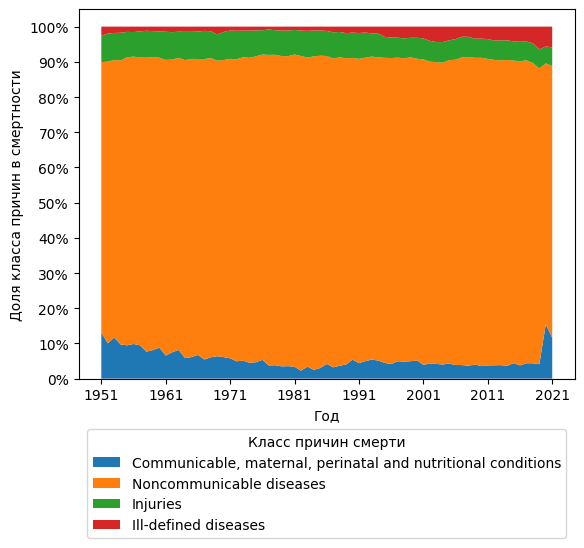

In [12]:
# Пример визуализации динамики структуры смертности по причинам в Швейцарии
pivot = pd.pivot_table(
    data=df2,
    index='Year',
    columns='CauseCategory',
    values='D',
    aggfunc='sum'
)
sum = pivot.sum(axis=1)

x = [int(year) for year in pivot.index]
communicable = pivot['Communicable, maternal, perinatal and nutritional conditions'] / sum
noncommunicable = pivot['Noncommunicable diseases'] / sum
injuries = pivot['Injuries'] / sum
ill_defined = pivot['Ill-defined diseases'] / sum

plt.stackplot(x, communicable, noncommunicable, injuries, ill_defined,
              labels=[
                'Communicable, maternal, perinatal and nutritional conditions',
                'Noncommunicable diseases',
                'Injuries',
                'Ill-defined diseases'])
plt.xticks(np.arange(min(x), max(x)+1, 10.0))
plt.yticks(np.arange(0, 1.01, 0.1), [str(xi) + '%' for xi in np.arange(0, 101, 10)])
plt.legend(title='Класс причин смерти', loc='lower center', ncols=1, bbox_to_anchor=(0.5, -0.45))
plt.xlabel('Год')
plt.ylabel('Доля класса причин в смертности')
plt.show()